# Project: Determine Classifier strengths

### Instructions: <br>
- Look at multiple real (as in "not simulated") classification data sets and apply 2-3 classifiers. <br> 
- For each method, find at least one dataset where the chosen method is best (e.g. by performing cross-validation) <br>and the other two methods do not perform as well. <br> There is an extensive list of websites where you can find datasets on the course PM.<br>
-  Explain why the respective classifier is best by inspecting the features <br> e.g. through suitable plots<br>
-  Make sure to properly take care of e.g. stratification if predictors or classes are unbalanced.<br>

In [40]:
import numpy as np
from sklearn import datasets, neighbors, preprocessing, utils, metrics, linear_model 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
#import kaggle

In [21]:
class Dataset:
    """
    Class: dataset
    import_dataset: choose between iris and digits.
    standardise_data: standardise the data set
    shuffle_data: shuffle the data set
    split_data: create n_folds number of folds
    """
    
    def __init__(self, dataset): 
        self.X = None
        self.t = None
        self.dataset = dataset
        self.X_folds = []
        self.t_folds = [] 
        self.target_names = None
        
    def import_dataset(self):
        if self.dataset =='iris':
            data = datasets.load_iris()
        if self.dataset == 'digits':
            data = datasets.load_digits()
        if self.dataset == 'breast_cancer':
            data = datasets.load_breast_cancer()     
        if self.dataset == 'wine':
            data = datasets.load_wine()
       
        self.X = data['data']
        self.t = data['target']
        self.target_names = data['target_names']

    def standardise_data(self):
        standard_scaled = preprocessing.StandardScaler()
        self.X = standard_scaled.fit_transform(self.X)

    def shuffle_data(self):
        self.X, self.t = utils.shuffle(self.X,self.t)
    
    def split_data(self, n_fold):
        self.X_folds = []
        self.t_folds = []
        size_data = len(self.t)
        size_fold = int(size_data/n_fold)
        
        if size_data%n_fold == 0:
            start_index = 0
            stop_index = size_fold 
            for i in range(n_fold):
                self.X_folds.append(self.X[start_index:stop_index])
                self.t_folds.append(self.t[start_index:stop_index])
                
                start_index += size_fold
                stop_index += size_fold
        else:
            remainder = size_data%n_fold
            start_index = 0
            stop_index = size_fold + 1
            remainder -= 1
            
            for i in range(n_fold):
                self.X_folds.append(self.X[start_index:stop_index])
                self.t_folds.append(self.t[start_index:stop_index])
                
                if remainder == 0:
                    start_index = stop_index 
                    stop_index += size_fold
                
                else: 
                    start_index = stop_index 
                    stop_index += size_fold + 1
                    remainder -= 1  

In [37]:
def run_knn(data, n_folds, k_neighbours):
    #
    dataset = Dataset(data)
    dataset.import_dataset()
    dataset.standardise_data()
    dataset.shuffle_data()
    dataset.split_data(n_folds)
    #print(len(np.concatenate(iris.t_folds)))
    
    accuracy_score = []
    test_data_index = 0
    for i in range(n_folds): 
        X_test = dataset.X_folds[test_data_index]
        t_test = dataset.t_folds[test_data_index]

        X_train = np.concatenate(np.delete(dataset.X_folds, test_data_index, 0))
        t_train = np.concatenate(np.delete(dataset.t_folds, test_data_index, 0))
        
        #print("num_0:", np.sum(t_train==0),"num_1:", np.sum(t_train==1),"num_2:", np.sum(t_train==2))

        classifier = neighbors.KNeighborsClassifier(k_neighbours)
        classifier.fit(X_train, t_train)
        Z = classifier.predict(X_test)
        
        accuracy = metrics.accuracy_score(t_test, Z)
        accuracy_score.append(accuracy)
        test_data_index += 1
        #print(f'accuracy: {accuracy}, fold: {test_data_index}')
        
    average_test_accuracy = np.sum(accuracy_score)/len(accuracy_score)
    print('average test accuracy:', average_test_accuracy)
    
    # Plot the confusion matrix
    confusion_matrix = metrics.plot_confusion_matrix(classifier, X_test, t_test,
                                     display_labels=dataset.target_names,
                                     cmap=plt.cm.Blues,
                                     normalize='true')
    confusion_matrix.ax_.set_title(f'Confusion nmatrix for knn classification on {data} dataset. \
                                   \n k={k_neighbours}, folds={n_folds}')

    #print(confusion_matrix.confusion_matrix)

    plt.show()
    return classifier, accuracy_score


average test accuracy: 0.9666353383458647


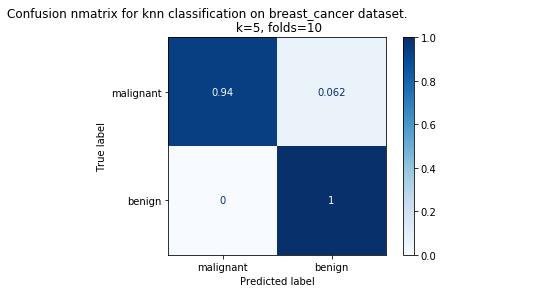

[0.9824561403508771, 0.9649122807017544, 0.9298245614035088, 0.9298245614035088, 1.0, 0.9649122807017544, 0.9122807017543859, 1.0, 1.0, 0.9821428571428571]


In [39]:
knn = run_knn('breast_cancer', n_folds=10, k_neighbours=5)
classifier = knn[0]
accuracy = knn[1]
print(accuracy)

In [6]:
knn = run_knn('digits', n_folds=10, k_neighbours=5)
classifier = knn[0]
accuracy = knn[1]
#print(accuracy)

average test accuracy: 0.9755276225946616


In [41]:
def run_classifier(data, classification_method, n_folds, k_neighbours=5):
    #
    dataset = Dataset(data)
    dataset.import_dataset()
    dataset.standardise_data()
    dataset.shuffle_data()
    dataset.split_data(n_folds)
    
    accuracy_score = []
    test_data_index = 0
    for i in range(n_folds): 
        X_test = dataset.X_folds[test_data_index]
        t_test = dataset.t_folds[test_data_index]

        X_train = np.concatenate(np.delete(dataset.X_folds, test_data_index, 0))
        t_train = np.concatenate(np.delete(dataset.t_folds, test_data_index, 0))
        
        #print("num_0:", np.sum(t_train==0),"num_1:", np.sum(t_train==1),"num_2:", np.sum(t_train==2))
        if classification_method == 'knn':
            classifier = neighbors.KNeighborsClassifier(k_neighbours)
        if classification_method == 'logistic_regression':
            classifier = linear_model.LogisticRegression()
       
        classifier.fit(X_train, t_train)
        Z = classifier.predict(X_test)
        
        accuracy = metrics.accuracy_score(t_test, Z)
        accuracy_score.append(accuracy)
        test_data_index += 1
        #print(f'accuracy: {accuracy}, fold: {test_data_index}')
        
    average_test_accuracy = np.sum(accuracy_score)/len(accuracy_score)
    print('average test accuracy:', average_test_accuracy)
    
    # Plot the confusion matrix
    confusion_matrix = metrics.plot_confusion_matrix(classifier, X_test, t_test,
                                     display_labels=dataset.target_names,
                                     cmap=plt.cm.Blues,
                                     normalize='true')
    confusion_matrix.ax_.set_title(f'Confusion nmatrix for knn classification on {data} dataset. \
                                   \n k={k_neighbours}, folds={n_folds}')

    #print(confusion_matrix.confusion_matrix)

    plt.show()
    return classifier, accuracy_score


average test accuracy: 0.9666353383458647


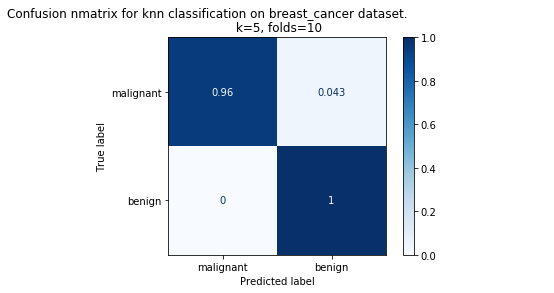

[0.9824561403508771, 0.9473684210526315, 0.8771929824561403, 0.9473684210526315, 0.9824561403508771, 1.0, 1.0, 0.9649122807017544, 0.9824561403508771, 0.9821428571428571]


In [45]:
knn = run_classifier('wine','knn', n_folds=10, k_neighbours=5)
classifier = knn[0]
accuracy = knn[1]
print(accuracy)

average test accuracy: 0.9777777777777779


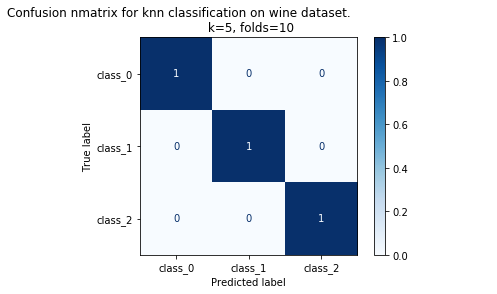

In [47]:
knn = run_classifier('wine','logistic_regression', n_folds=10, k_neighbours=5)
classifier = knn[0]
accuracy = knn[1]
#print(accuracy)

In [ ]:
# TESTING TO CREATE NICE KNN PLOT, probably should discard this code

dataset = 'iris'
n_folds = 10
k_neighbours = 20
    
data = Dataset(dataset)
data.import_dataset()
#data.standardise_data()
data.shuffle_data()
data.split_data(n_folds)

X = data.X
t = data.t

X_test = data.X_folds[0]
t_test = data.t_folds[0]

X_train = np.concatenate(np.delete(data.X_folds, 0, 0))
t_train = np.concatenate(np.delete(data.t_folds, 0, 0))

classifier = neighbors.KNeighborsClassifier(k_neighbours)
classifier.fit(X_train, t_train)

Z = classifier.predict(X_test)

# Change to accuracy or somerthing more correct!!!!!!
score = np.sum(Z==t_test)/len(Z)

accuracy = metrics.accuracy_score(t_test, Z)

print(f'Score: {score}, accuracy: {accuracy}, fold: {0}')
print('len data',len(t_train), len(t_test))

h = .01  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['blue','violet','lime','pink','red'])
cmap_bold = ListedColormap(['navy','purple','green','hotpink','maroon'])


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=cmap_bold, edgecolor='grey')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title(f"kNN classification k = {k_neighbours}")

plt.show()